# Set-up

In [21]:
import glob
import gzip
import shutil
import pandas
import numpy as np
import tqdm
import lxml.etree as ET
from collections import namedtuple, Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
import math

def is_nan(d):
    if isinstance(d, float) and not math.isnan(d):
        return int(d)
    return -999

## XSL Attention

In [4]:
transform = ET.XSLT(ET.fromstring("""<xsl:stylesheet xmlns:xsl="http://www.w3.org/1999/XSL/Transform"
    xmlns:xs="http://www.w3.org/2001/XMLSchema"
    exclude-result-prefixes="xs"
    version="1.0">
    <xsl:output omit-xml-declaration="yes" />
    <xsl:param name="lemma"/>
    <xsl:param name="frequence"/>
    <xsl:param name="nom"/>
    <xsl:param name="siecle"/>
    <xsl:template match="div">
        <p>
         <xsl:apply-templates select="bibl" />
         <xsl:apply-templates select=".//w" />
        </p>
    </xsl:template>
    <xsl:template match="bibl">
        <b><xsl:value-of select="$nom" /></b>, <xsl:value-of select="$siecle" /> Siècle (<em><xsl:value-of select="./idno/text()"/></em>)<br />
    </xsl:template>
    <xsl:template match="w">
        <xsl:choose>
            <xsl:when test="@lemma = $lemma">
                <span style="color: red;"><xsl:value-of select="./text()"/> (<xsl:value-of select="$frequence"/>)</span>
            </xsl:when>
            <xsl:otherwise>
                <xsl:value-of select="./text()"/>
            </xsl:otherwise>
        </xsl:choose>
        <xsl:text> </xsl:text>
    </xsl:template>
</xsl:stylesheet>"""))

## Dates et autres joyeusetés

In [5]:
dates = {
    row.URN: (row.Birth+20) // 100
    for _, row in pandas.read_csv("../these/data/raw/datation.tsv", delimiter="\t").iterrows()
}
names = {
    row.URN: row["Nom FR"]
    for _, row in pandas.read_csv("../these/data/raw/datation.tsv", delimiter="\t").iterrows()
}

def get_urn(fp):
    ns, tg = fp.split("/")[-1].split("--")[0].split("_")
    return f"urn:cts:{ns}:{tg}"
    
def get_date(row, source_fieldname="Source"):
    # greekLit_tlg0527.tlg019.obi-lat1--0.xml
    row.Century = dates.get(get_urn(row.Source))
    return row

def get_nom(row, source_fieldname="Source"):
    row.Nom = names.get(get_urn(row[source_fieldname]))
    return row

def get_nom_wrapper(field_name):
    def temp(row):
        return get_nom(row, field_name)
    
def get_date_wrapper(field_name):
    def temp(row):
        return get_date(row, field_name)

# Récupération des prédits positifs

In [1]:
tops = []

Cols = ["word", "lemma", "attention", "median", "std", "true_positive", "source", "model", "rank", "rel_rank"]
Data = namedtuple("Data", Cols)
PATH = "test_dumps/main*HAN*.csv.gz"

models = len(glob.glob(PATH))

occurences = Counter()
all_occurences = Counter()
analysis = defaultdict(list)
sents = defaultdict(list)

for file in tqdm.tqdm(glob.glob(PATH)):
    if "Enriched" in file:
        continue
    #print(file)
    df = pandas.read_csv(file)
    # print(data.head)
    df["attention"] = df["attention"].apply(lambda x: np.array(eval(x)))
    df["ok"] = df["prediction"] == df["label"]

    for i, row in df[df.prediction == "positive"].iterrows():
        xml = ET.parse(row.fp)
        if not sents[row.fp]:
            sents[row.fp] = list(map(str, xml.xpath("//w/@lemma")))
        lemmas = sents[row.fp]
        if row.ok == True and not analysis[row.fp]:
            analysis[row.fp] = list(map(str, xml.xpath("//w[@ana]/@lemma")))
        row.attention = row.attention[:len(lemmas)]
        occurences += Counter(lemmas)
        all_occurences  += Counter(lemmas)
        med = np.median(row.attention)
        std = row.attention.std()
        quantile = np.quantile(row.attention, 0.74)
        
        ranks = (
            1 + len(lemmas) - (row.attention.argsort().argsort()+1)
        )
        
        words = sorted([
            Data(w, l, a, med, std, row.ok, row.fp, file, rank, (rank-1)/len(lemmas))
            for w, a, l, rank in zip(row.sentence.split(), row.attention, lemmas, ranks)
        ], reverse=True, key=lambda x: x[2])

        for w in words:
            tops.append(w)
            
    for i, row in df[df.prediction == "negative"].iterrows():
        xml = ET.parse(row.fp)
        if not sents[row.fp]:
            sents[row.fp] = list(map(str, xml.xpath("//w/@lemma")))
        lemmas = sents[row.fp]
        all_occurences += Counter(lemmas)

100%|███████████████████████████████████████████| 40/40 [00:23<00:00,  1.71it/s]


In [2]:
ALL_ANALYSIS = set([val for anas in analysis.values() for val in anas])

In [3]:
#from collections import Counter
#most_common_words = Counter([w[1] for w in tops_lemma])
#most_common_words.most_common(100)

In [4]:
attentions = pandas.DataFrame(tops, columns=Cols).sort_values(
    "attention", ascending=False
)
attentions["difference"] = attentions["attention"] - (attentions["median"] + attentions["std"])

<AxesSubplot:>

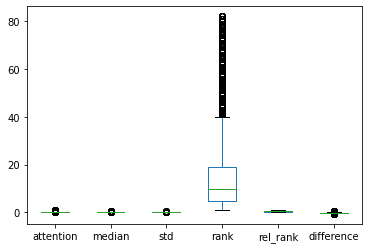

In [5]:
attentions.plot.box()

In [6]:
new_df = attentions[attentions.difference > 0.1].lemma.value_counts().reset_index()
new_df.columns = ["Lemma", "Frequency"]

new_df["RelFreq"] = new_df.Frequency
new_df["RealRelFreq"] = new_df.Frequency

def relfreq(row):
    row.RelFreq = row.Frequency / occurences[row.Lemma]
    return row


def realrelfreq(row):
    row.RealRelFreq = row.Frequency / all_occurences[row.Lemma]
    return row


new_df = new_df.apply(relfreq, axis=1)
new_df = new_df.apply(realrelfreq, axis=1)

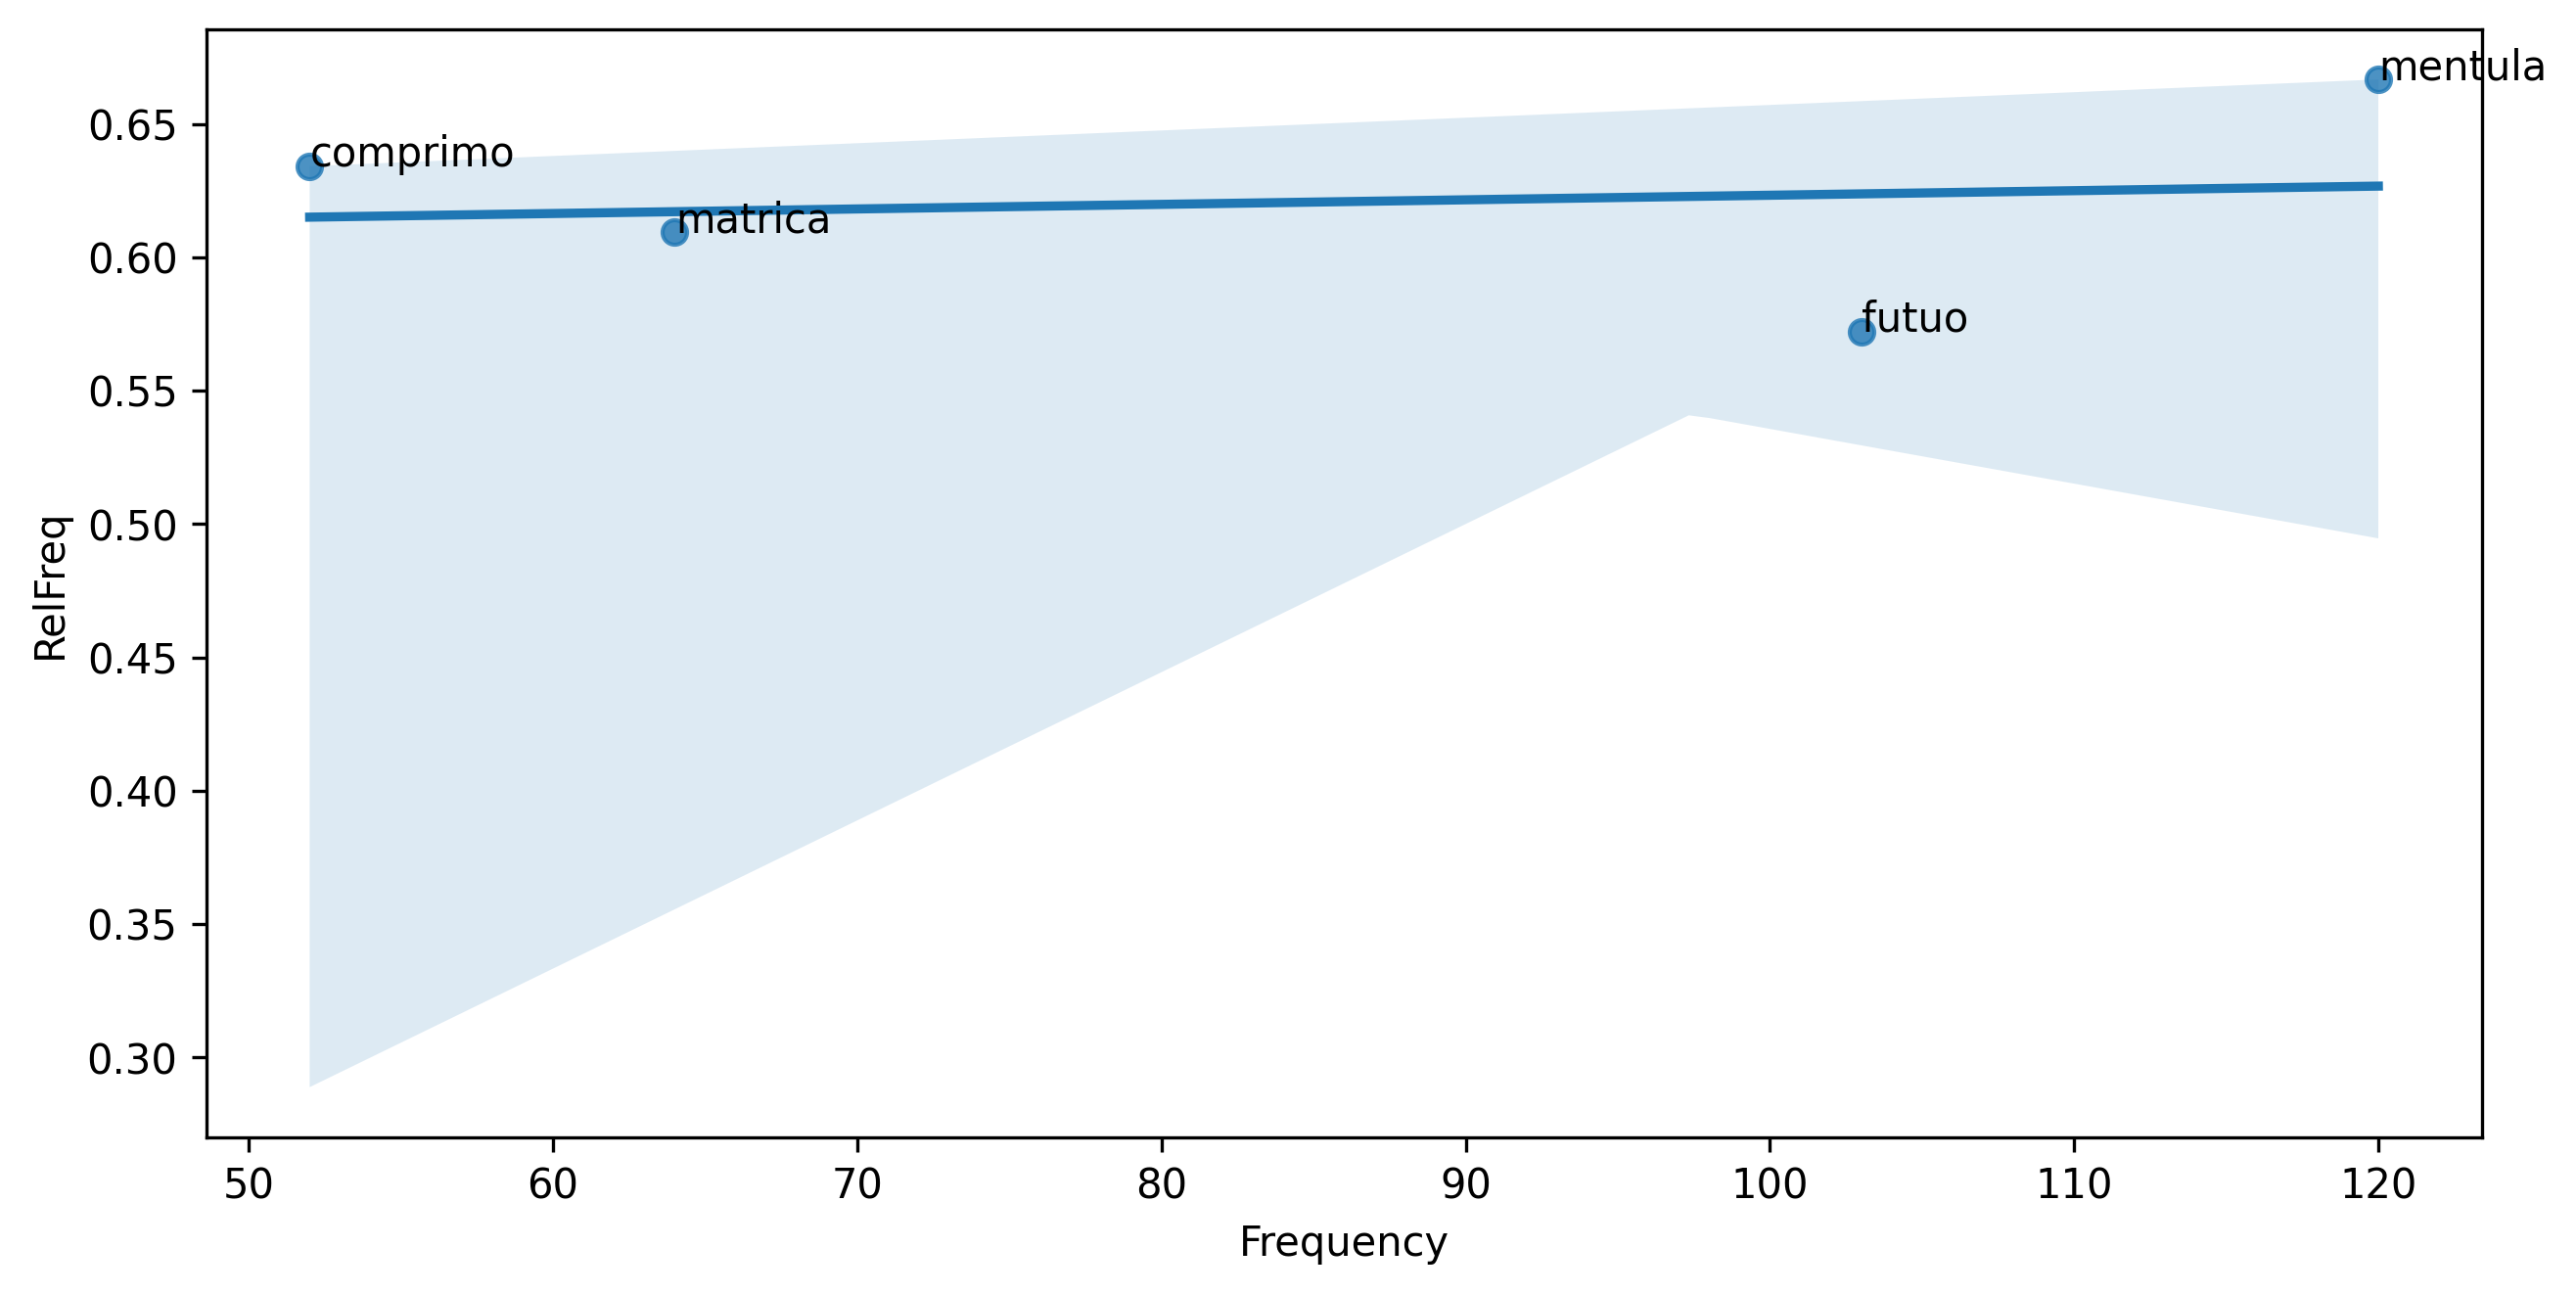

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

filtered_df = new_df.copy()


def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']+.02, point['y'], str(point['val']))
        
def plot_with_title(df, filtr, y="RelFreq", x="Frequency", **figurekwargs):
    figurekwargs.update(dict(dpi=300, figsize=(10,5)))
    
    fig = plt.figure(**figurekwargs)
    ax = fig.gca()

    ax = sns.regplot(
        x=x, # Horizontal axis
        y=y, # Vertical axis
        data=df[filtr], # Data source
        fit_reg=True, # Don't fix a regression line
        ax=ax)

    label_point(df[filtr][x], df[filtr][y], df[filtr].Lemma, ax=ax)
    
filtr = (filtered_df.Frequency > 50) & (filtered_df.RelFreq > .5)
plot_with_title(filtered_df, filtr=filtr, y="RelFreq")

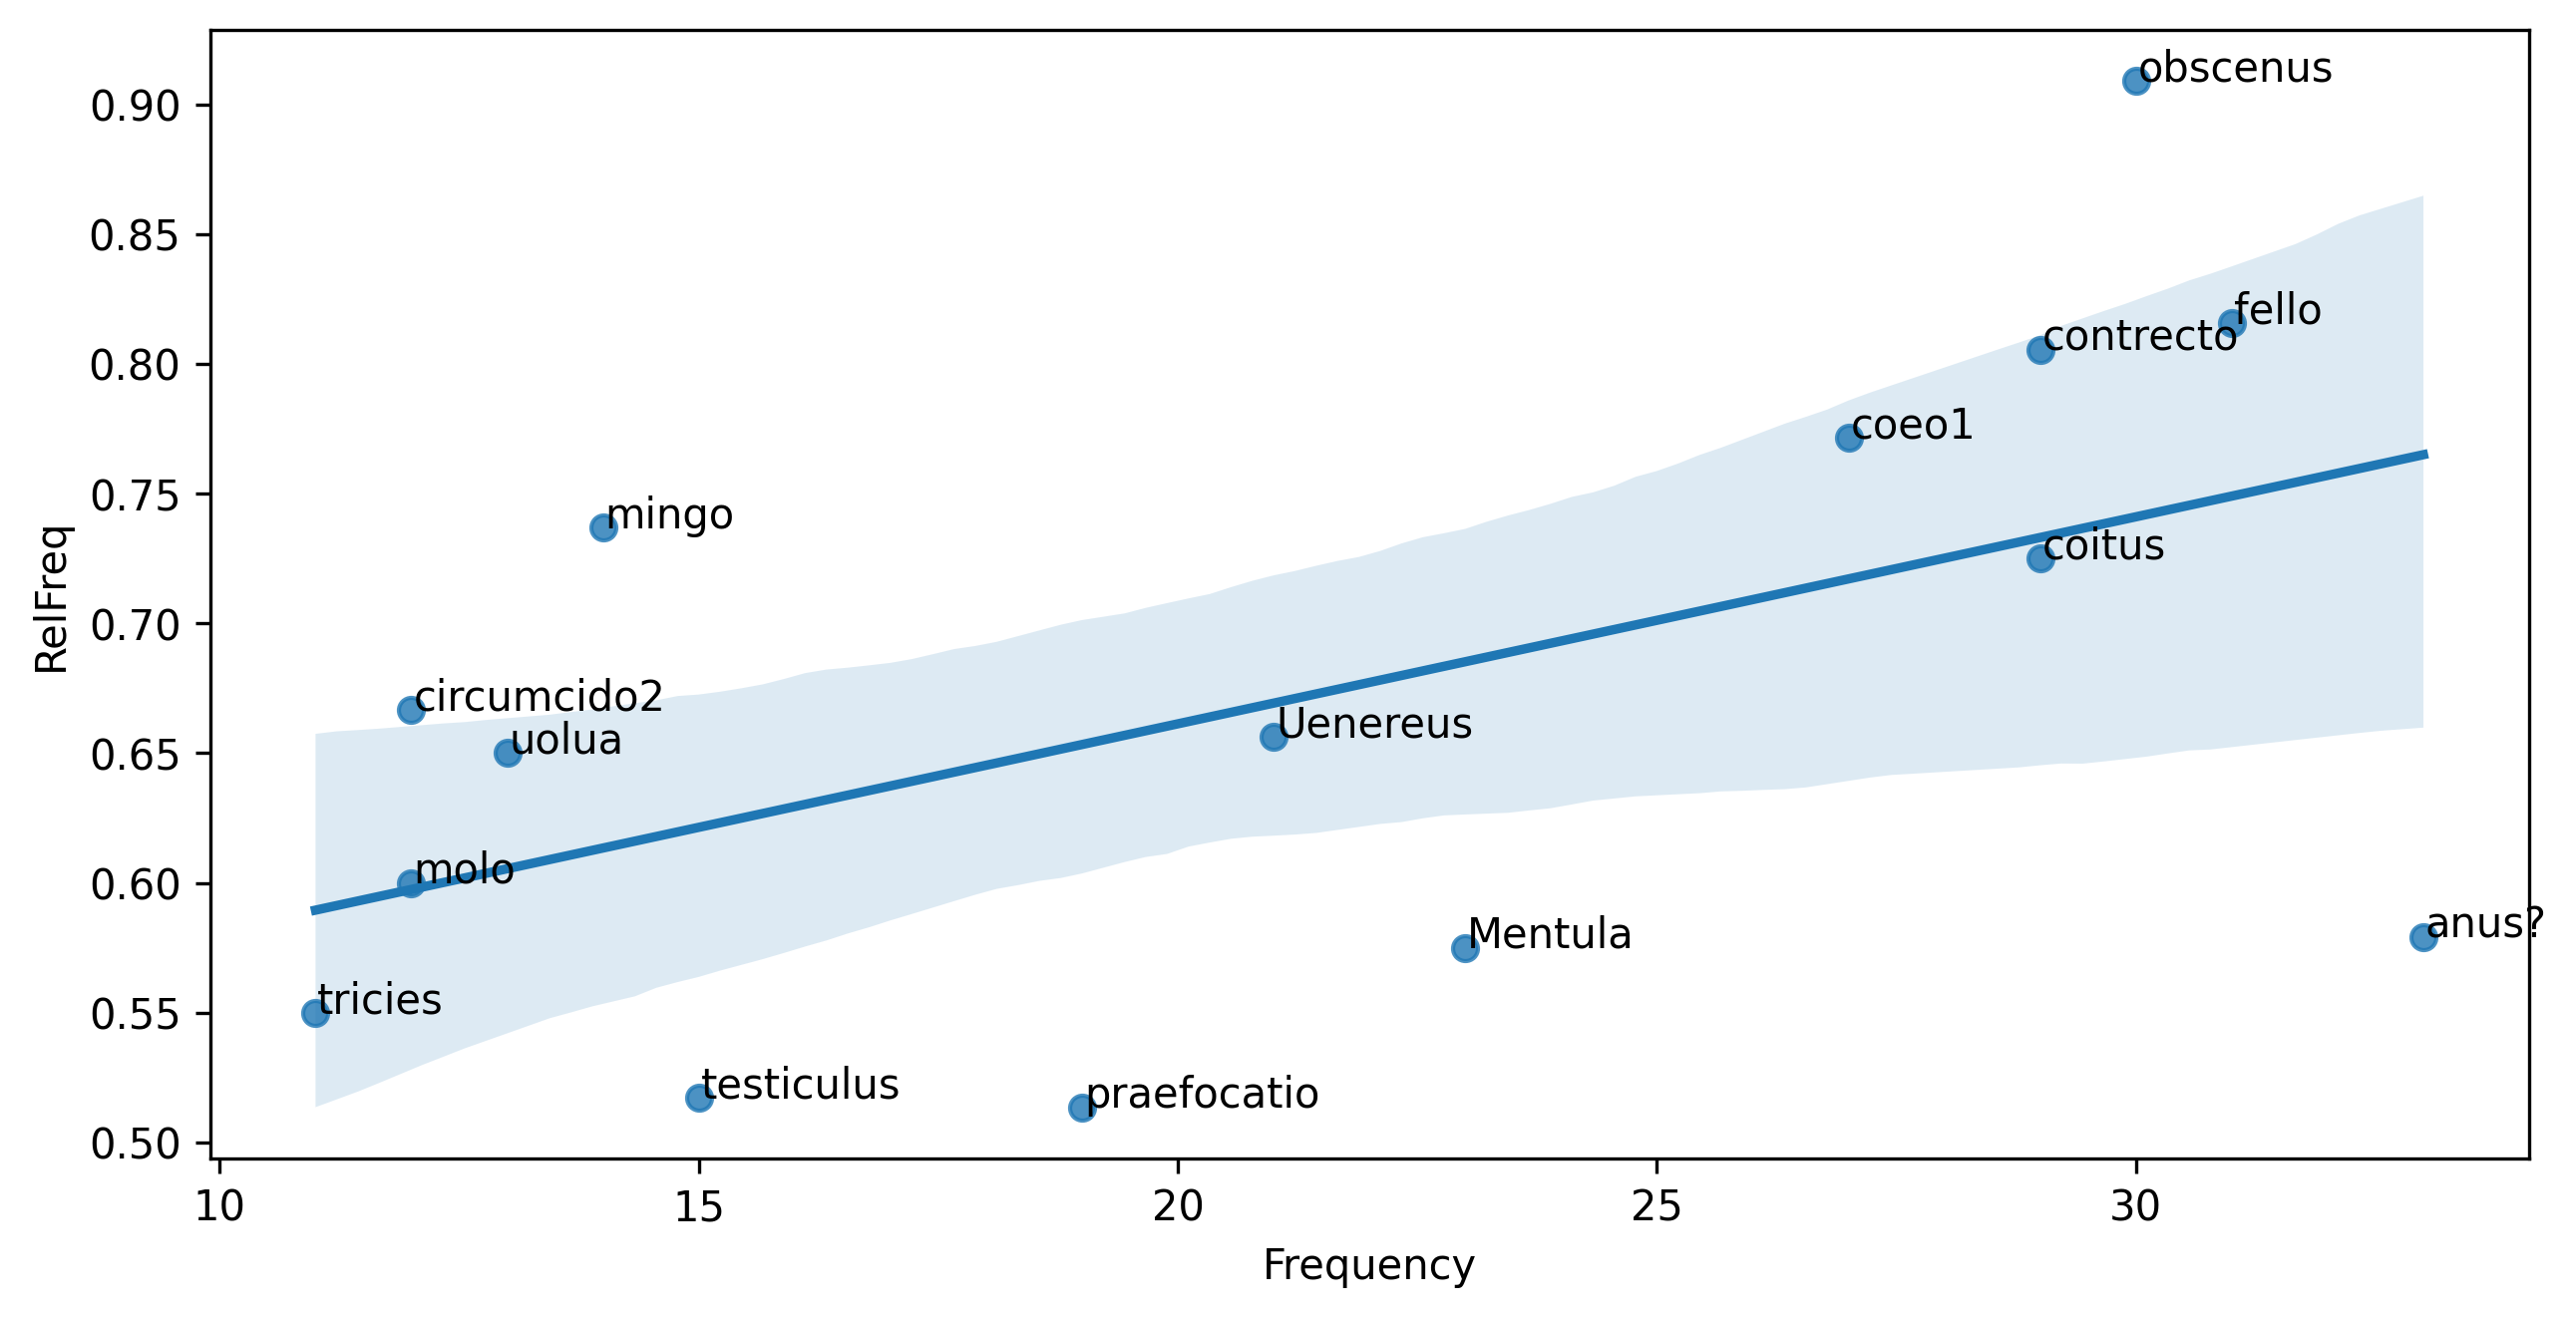

In [8]:
fltr = (filtered_df.Frequency < 50) & (filtered_df.Frequency > 10) & (filtered_df.RelFreq > .5)
plot_with_title(filtered_df, filtr=fltr, y="RelFreq")

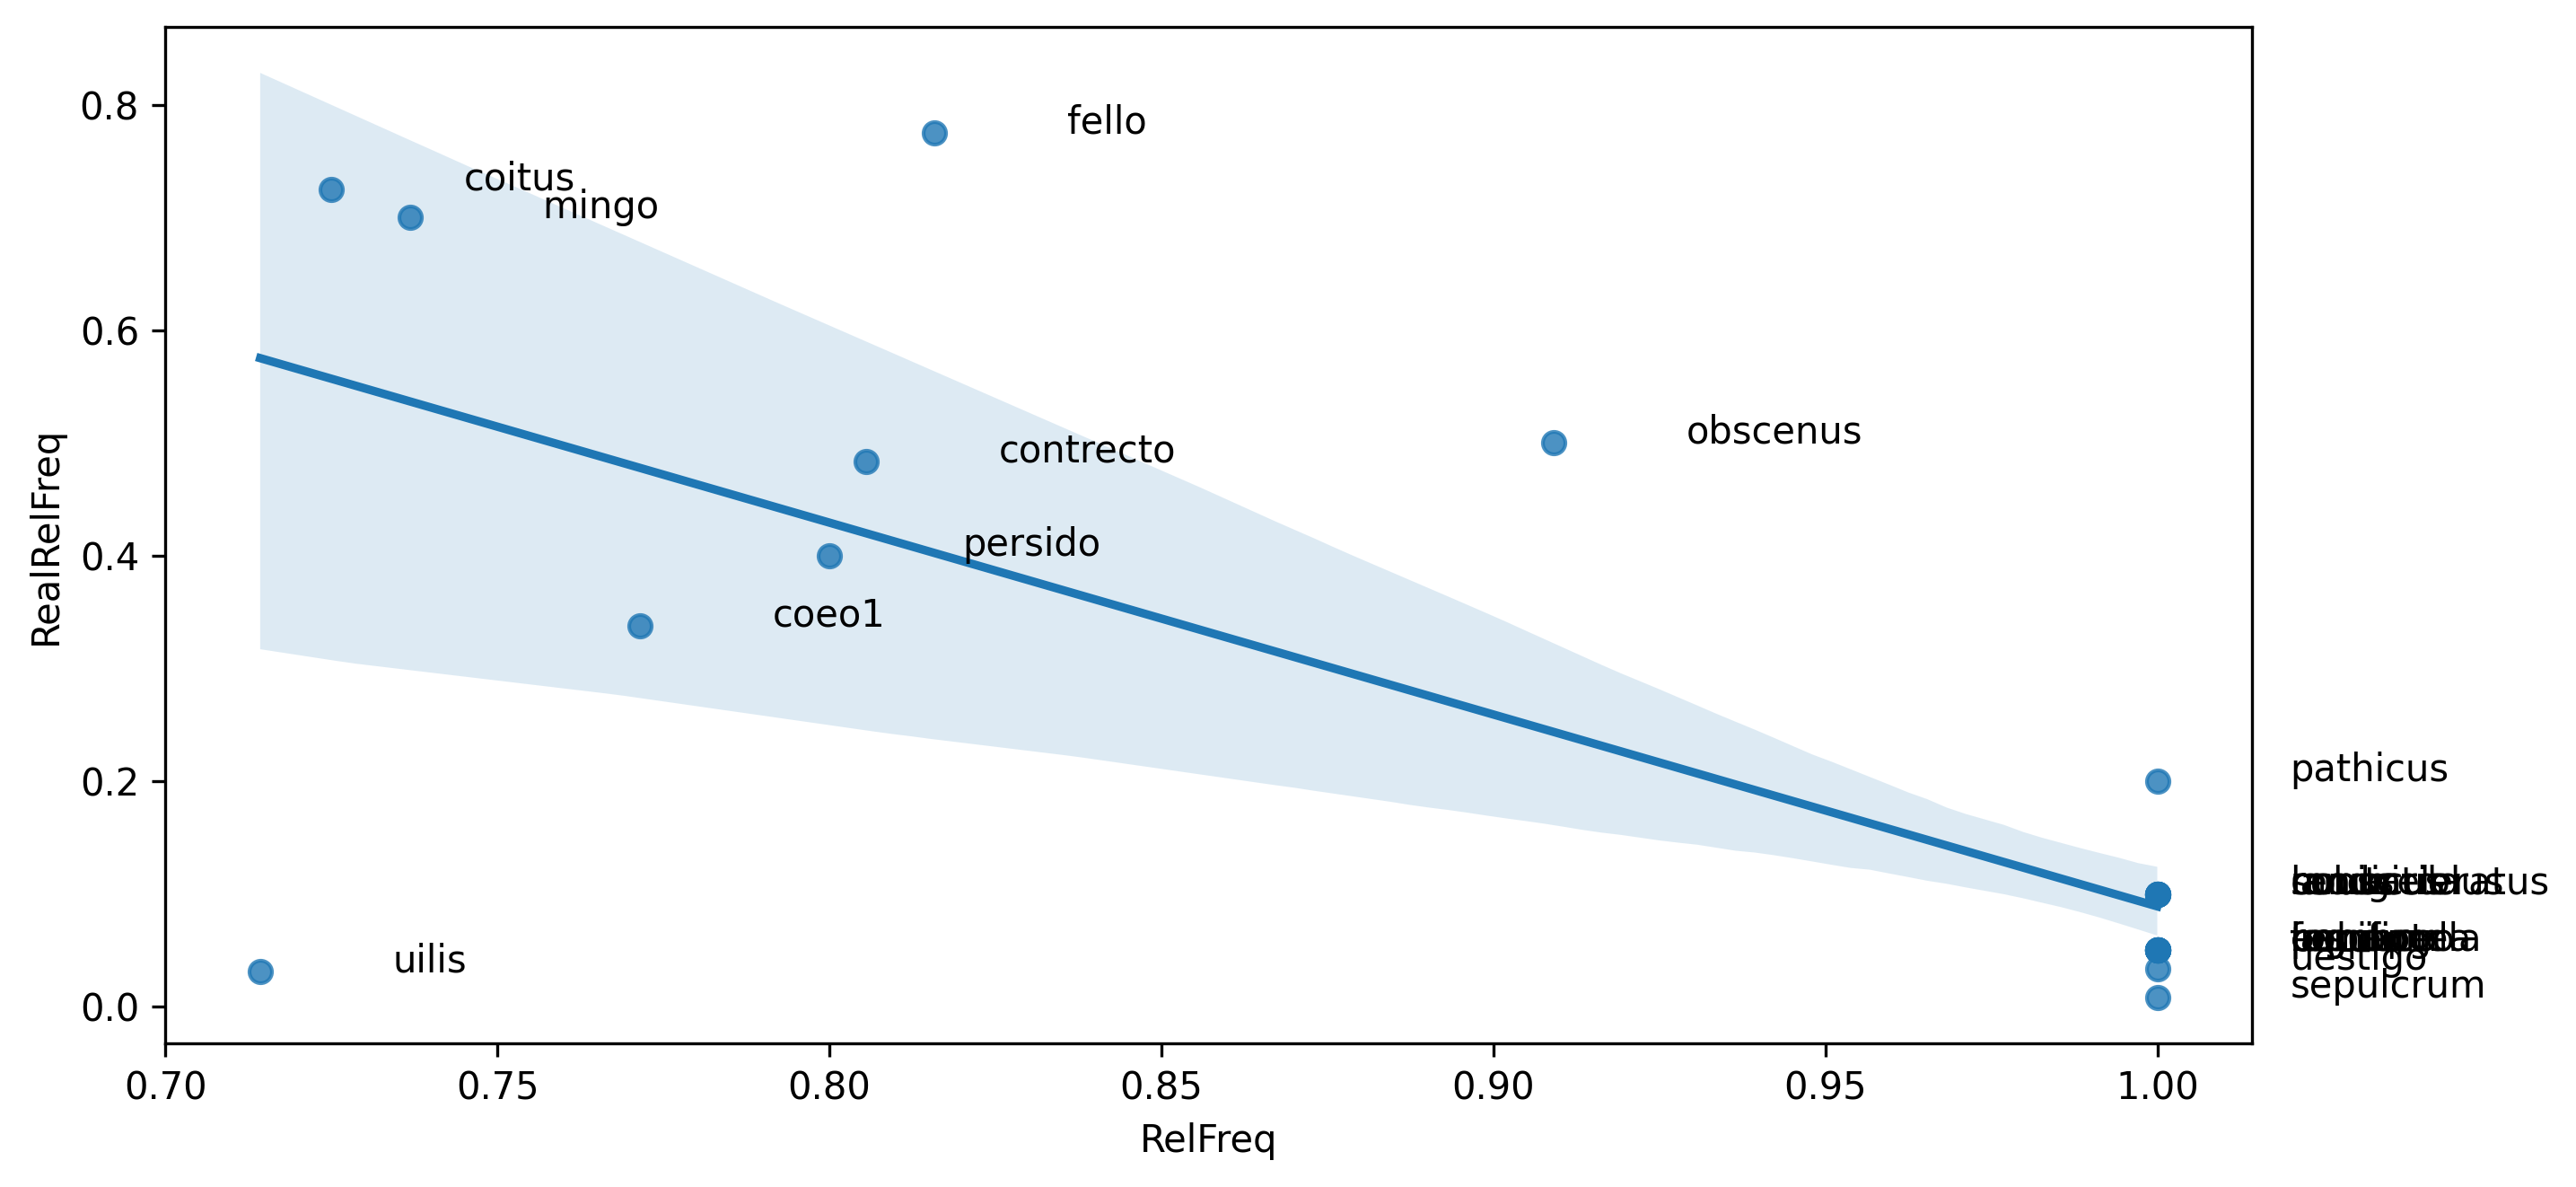

In [9]:
fltr = (filtered_df.RelFreq > .7)
plot_with_title(filtered_df, filtr=fltr, y="RealRelFreq", x="RelFreq")

In [10]:
beautiful_df = filtered_df.copy()[(filtered_df.RelFreq > .5) & (filtered_df.Frequency > 5)]
beautiful_df.columns = [
    "Lemme",
    "Occ(Quantile 0.65)",
    "Occ(.65) / Fréquence(Taggés positifs)",
    "Occ(.65) / Fréquence(Tous les échantillons)"
]
["Lemme"] + list(beautiful_df.columns)[-2:]
print(beautiful_df[["Lemme"] + list(beautiful_df.columns)[-2:]].to_latex(float_format=lambda x: f"{x:.2f}"))


\begin{tabular}{llrr}
\toprule
{} &        Lemme &  Occ(.65) / Fréquence(Taggés positifs) &  Occ(.65) / Fréquence(Tous les échantillons) \\
\midrule
1  &      mentula &                                   0.67 &                                         0.67 \\
2  &        futuo &                                   0.57 &                                         0.57 \\
6  &      matrica &                                   0.61 &                                         0.46 \\
8  &     comprimo &                                   0.63 &                                         0.33 \\
12 &        anus? &                                   0.58 &                                         0.55 \\
14 &        fello &                                   0.82 &                                         0.78 \\
15 &     obscenus &                                   0.91 &                                         0.50 \\
16 &       coitus &                                   0.72 &                            

0.15681207342759557
\begin{tabular}{llrr}
\toprule
{} &          lemme &  occurences &      attn \\
\midrule
72  &          sarus &           0 &  0.221155 \\
91  &          mingo &           0 &  0.240170 \\
90  &     alterutris &           0 &  0.240084 \\
89  &        moechor &           0 &  0.237461 \\
88  &          renus &           0 &  0.236074 \\
87  &        uehetus &           0 &  0.233636 \\
86  &       respergo &           0 &  0.232854 \\
85  &        uereter &           0 &  0.232280 \\
84  &       amiculum &           0 &  0.230132 \\
81  &        molitor &           0 &  0.226449 \\
76  &        caltula &           0 &  0.223298 \\
74  &        demitto &           0 &  0.222408 \\
144 &    mortariolus &           0 &  0.563690 \\
71  &      intorqueo &           0 &  0.215077 \\
70  &        iugulum &           0 &  0.213900 \\
63  &         fuluia &           0 &  0.203644 \\
57  &        tricies &           0 &  0.200513 \\
54  &          uolua &           0 &  0.1

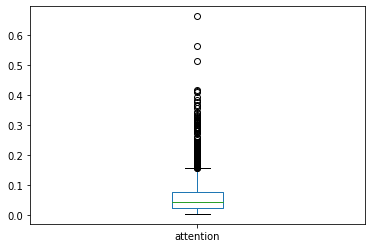

In [11]:
grouped = attentions.groupby("lemma").attention.mean().reset_index()
grouped.plot.box()

q3 = grouped.attention.quantile(.75)
q1 = grouped.attention.quantile(.25)

outliers = q3+1.5*(q3-q1)
print(outliers)

most_common = list(grouped[grouped.attention > outliers].sort_values("attention").lemma.unique())

# Calculer le pourcentage des lemmes dont l'attention est > .quartil ou un truc 
# du genre qui est un des termes annotés !

# Calculer le nombre de rank 1 aussi ? Calculer majorité de rank 1?
print(pd.DataFrame([
    {
        "lemme": lemme,
        "occurences": int(all_occurences[lemme]/models),
        "attn":grouped[grouped.lemma==lemme].attention.tolist()[0]
    }
    for lemme in most_common
]).sort_values("occurences").to_latex())

# Connexion entre Attention et Analyse d'Adams

<AxesSubplot:>

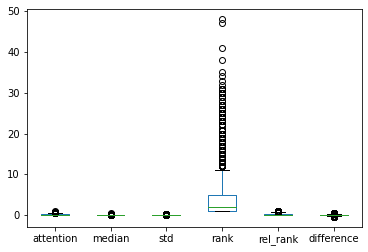

In [12]:
AdamsDf = attentions.copy()
AdamsDf["AdamsRank1"] = False
AdamsDf["Adams"] = False

def adams(row):
    row.Adams = row.lemma in analysis[row.source]
    row.AdamsRank1 = row["rank"] == 1 and row.Adams
    return row


AdamsDf = AdamsDf.apply(adams, axis=1)
AdamsDf[AdamsDf.Adams == True].plot.box("rank")

,word,lemma,attention,median,std,true_positive,source,model,rank,rel_rank,difference,AdamsRank1,Adams
42281,utero,uterus,0.028452,0.016776,0.019194,True,/home/thibault/dev/these-corpus/data/757.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-256...,22,0.428571,-0.007518,False,True
69981,utero,uterus,0.028418,0.024444,0.019513,True,/home/thibault/dev/these-corpus/data/757.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-256...,21,0.408163,-0.015540,False,True
70276,fututorum,futuo,0.028286,0.038503,0.017648,True,/home/thibault/dev/these-corpus/data/1012.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-256...,21,0.645161,-0.027865,False,True
21127,latus,latus1,0.027070,0.039680,0.024321,True,/home/thibault/dev/these-corpus/data/207.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-256...,21,0.952381,-0.036931,False,True
54028,uterum,uterus,0.024524,0.025005,0.016541,True,/home/thibault/dev/these-corpus/data/714.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-128...,22,0.500000,-0.017022,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43115,çum,cum2,0.004464,0.027945,0.037386,True,/home/thibault/dev/these-corpus/data/1479.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-256...,23,0.785714,-0.060867,False,True
27234,patrare,patro,0.004188,0.003898,0.027612,True,/home/thibault/dev/these-corpus/data/1190.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-256...,27,0.426230,-0.027322,False,True
65219,polluisti,polluo,0.002881,0.009506,0.025641,True,/home/thibault/dev/these-corpus/data/2187.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-128...,31,0.697674,-0.032266,False,True
47366,patrare,patro,0.002276,0.002276,0.024532,True,/home/thibault/dev/these-corpus/data/1190.xml,test_dumps/main.AggloMSD-HAN-None-Word2Vec-256...,31,0.491803,-0.024532,False,True


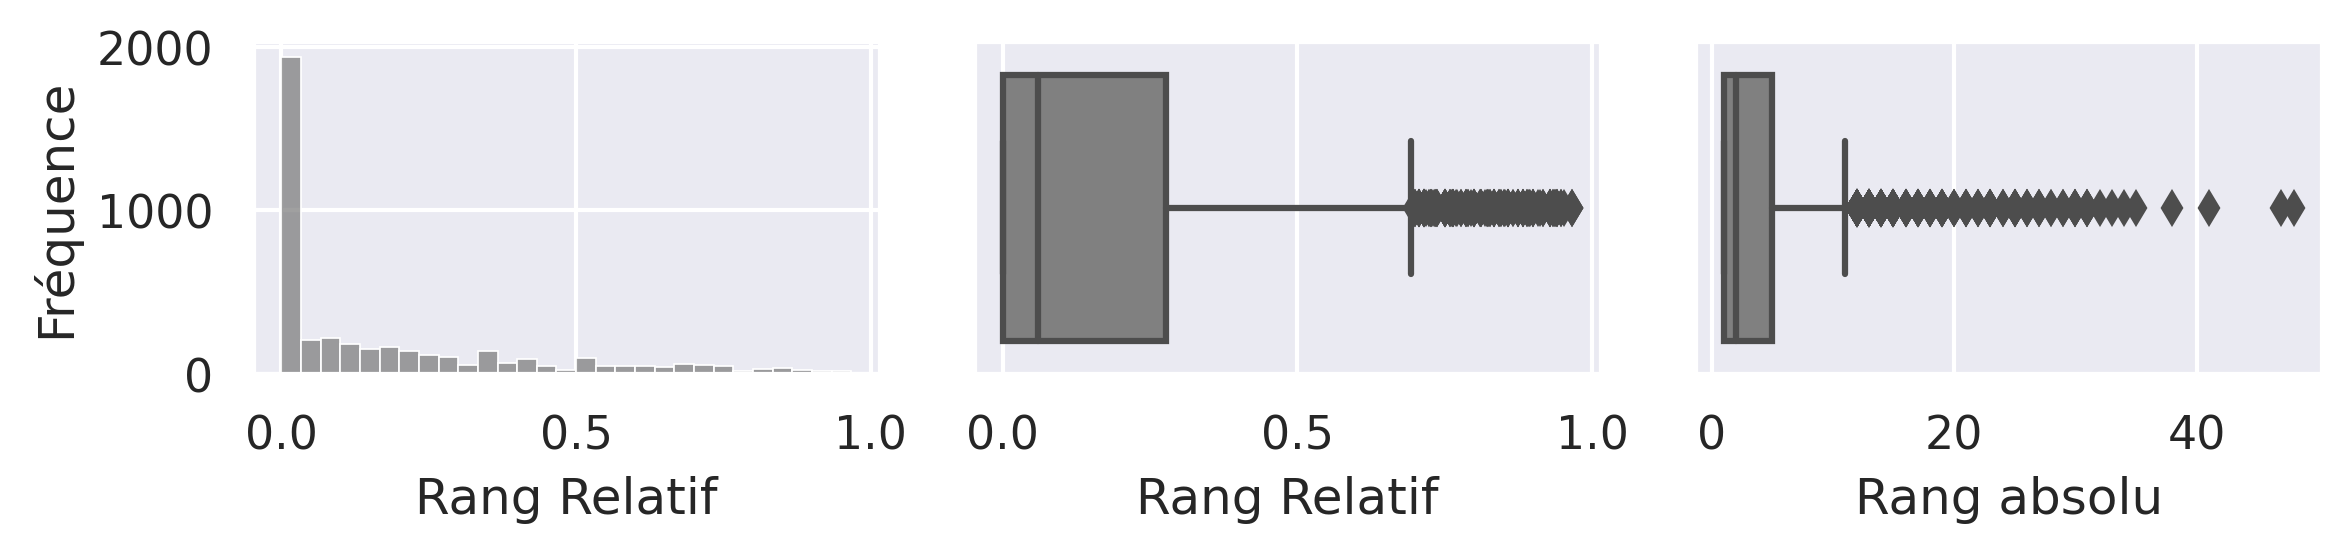

In [62]:
flt = AdamsDf[AdamsDf.Adams == True]


sns.set_theme()
figure, (ax1, ax3, ax2) = plt.subplots(1, 3, dpi=300, figsize=(8,2), tight_layout=True)
sns.histplot(data=flt, x="rel_rank", ax=ax1, color="gray")
ax1.set_xlabel("Rang Relatif")
ax1.set_ylabel("Fréquence")


sns.boxplot(data=flt, x="rank", ax=ax2, color="gray")
ax2.set_ylabel("")
ax2.set_xlabel("Rang absolu")

sns.boxplot(data=flt, x="rel_rank", ax=ax3, color="gray")
#ax2.set_yticklabels(ax.get_yticks(), rotation = 90)
ax3.set_ylabel("")
ax3.set_xlabel("Rang Relatif")

flt.describe()

## Ranks éloignés et phrases

In [92]:
#High ranks ?
# Probleme du rang / lemme: si le lemme est plusieurs fois dans la phrase par exemple
low_ranks = flt[flt["rank"]> 20].copy()

done = []
for idx, row in low_ranks.iterrows():
    #print(row.Lemme, row.Fréquence)
    #print(row.Lemme)
    if row.source in done:
        continue
    done.append(row.source)
    xml = ET.parse(row.source)
    urn = str(xml.xpath("//idno[@type='CTS_URN']/text()")[0])
    #rint(urn)
    display(HTML(str(transform(
        xml,
        lemma=f"'{row.lemma}'",
        frequence=f"'{row['rank']}'",
        nom=f"\"{names.get(urn, 'Inconnu')}\"",
        siecle=f"'{int(is_nan(dates.get(urn, -999)))}'".replace("-999", "Erreur"),
    ))))
    print("====================\n")

# Connexion entre Attention et Faux Positifs

## Navigation dans les faux positifs

In [14]:
rank1_false_positives = attentions[
    (attentions.true_positive == False) & (attentions["rank"] == 1)
].lemma.value_counts().reset_index()


rank1_false_positives.columns = ["Lemme", "Fréquence en rang 1"]
rank1_false_positives["Connu comme positif"] = False

def is_known(row):
    row["Connu comme positif"] = row.Lemme in ALL_ANALYSIS
    return row
    
rank1_false_positives = rank1_false_positives.apply(is_known, axis=1)


rank1_FP_allFreqs = rank1_false_positives["Fréquence en rang 1"].sum()
print(rank1_FP_allFreqs)
rank1_FP_allFreqs_knowns = rank1_false_positives[
    rank1_false_positives["Connu comme positif"] == True
]["Fréquence en rang 1"].sum()
print(rank1_FP_allFreqs_knowns / rank1_FP_allFreqs)

fp_connus = sorted(list(rank1_false_positives[
        rank1_false_positives["Connu comme positif"] == True
    ].Lemme.unique()))

print(fp_connus)

print(
    rank1_false_positives[
        (rank1_false_positives["Connu comme positif"] == False) & \
        (rank1_false_positives["Fréquence en rang 1"] > 1)
    ].to_markdown()
)

fp_interessants = ["amor", "masculus", "femineus", "caltula", "fullo", "lumbus", "concubitus", "uerecundus", "mensturo", 
                   "puella", "pudicus", "mulier", "nox"] + fp_connus

677
0.2895125553914328
['Uenus', 'coitus', 'comprimo', 'corrumpo', 'cum2', 'cum3', 'genitalis', 'gremium', 'iaceo', 'inguen', 'iniuria', 'libido', 'ludo', 'matricus', 'medius', 'misceo', 'muliebris', 'obscenus', 'pes', 'sinus', 'uoluto', 'usus', 'uterus', 'uulua']
|     | Lemme         |   Fréquence en rang 1 | Connu comme positif   |
|----:|:--------------|----------------------:|:----------------------|
|   2 | amor          |                    19 | False                 |
|   8 | ferocitas     |                    14 | False                 |
|   9 | caltula       |                    13 | False                 |
|  11 | fullo         |                    10 | False                 |
|  12 | delibuo       |                    10 | False                 |
|  13 | .             |                     9 | False                 |
|  14 | inquino       |                     9 | False                 |
|  15 | menstruo      |                     9 | False                 |
|  16 | confleo

## Mécanisme de récupération des dates

## Récupération des textes avec des faux positifs intéressants

In [16]:
fp_texts = attentions[
    (attentions["rank"] == 1) & (attentions.lemma.isin(fp_interessants)) & (attentions.true_positive == False)
][["lemma", "attention", "source"]]

fp_texts_counted = fp_texts.value_counts(["lemma", "source"]).reset_index()
fp_texts_counted.columns = ["Lemme", "Source", "Fréquence"]
fp_texts_counted["Century"] = 0

fp_texts_counted = fp_texts_counted.apply(get_date, axis=1)

### Affichage HTML

In [18]:
from IPython.core.display import display, HTML
import math

def is_nan(d):
    if isinstance(d, float) and not math.isnan(d):
        return int(d)
    return -999

for idx, row in fp_texts_counted.iterrows():
    #print(row.Lemme, row.Fréquence)
    #print(row.Lemme)
    display(HTML(str(transform(
        ET.parse(row.Source),
        lemma=f"'{row.Lemme}'",
        frequence=f"'{row.Fréquence/models*100:.2f}%'",
        nom=f"'{names[get_urn(row.Source)]}'",
        siecle=f"'{int(is_nan(dates[get_urn(row.Source)]))}'".replace("-999", "Erreur"),
    ))))
    print("====================\n")

Text(0, 0.5, "Nombre de faux positifs\nà termes 'ambigus'")

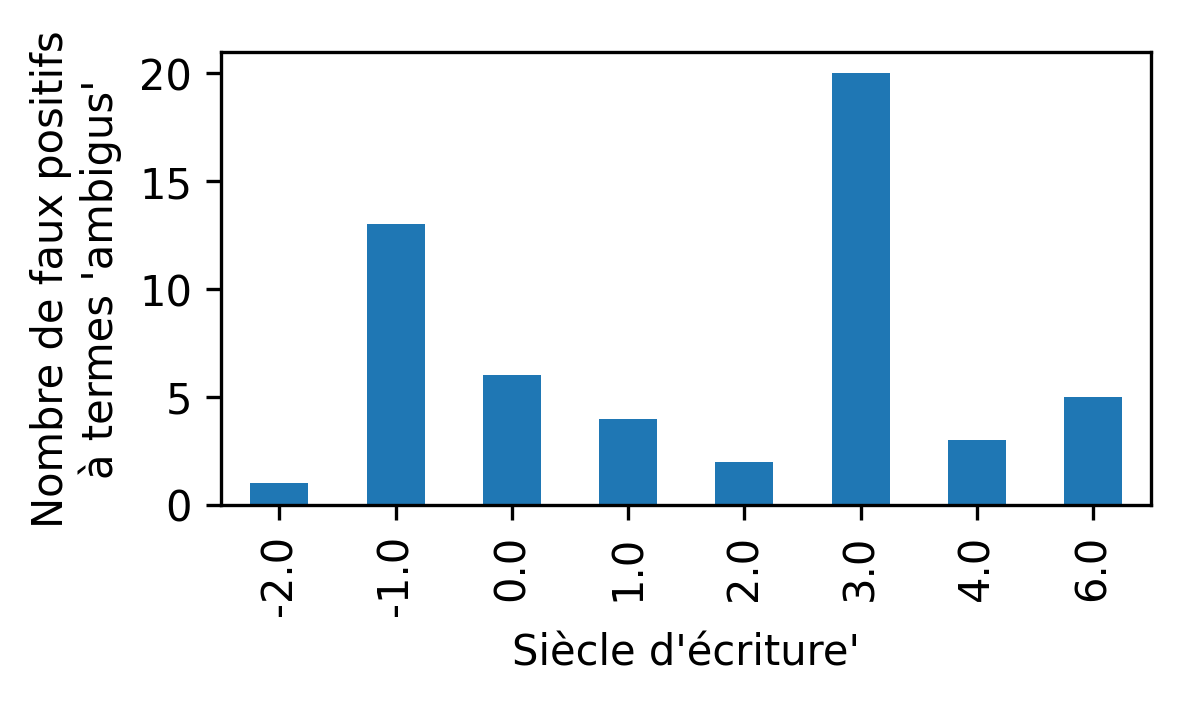

In [19]:
fig = plt.figure(dpi=300, figsize=(4,2))
ax = fig.gca()
fp_texts_counted.Century.value_counts().reset_index().sort_values("index").plot.bar(x="index", ax=ax)
ax.get_legend().remove()
ax.set_xlabel("Siècle d'écriture'")
ax.set_ylabel("Nombre de faux positifs\nà termes 'ambigus'")

## Période de tous les faux positifs

Text(0, 0.5, "Nombre de faux positifs\nà termes 'ambigus'")

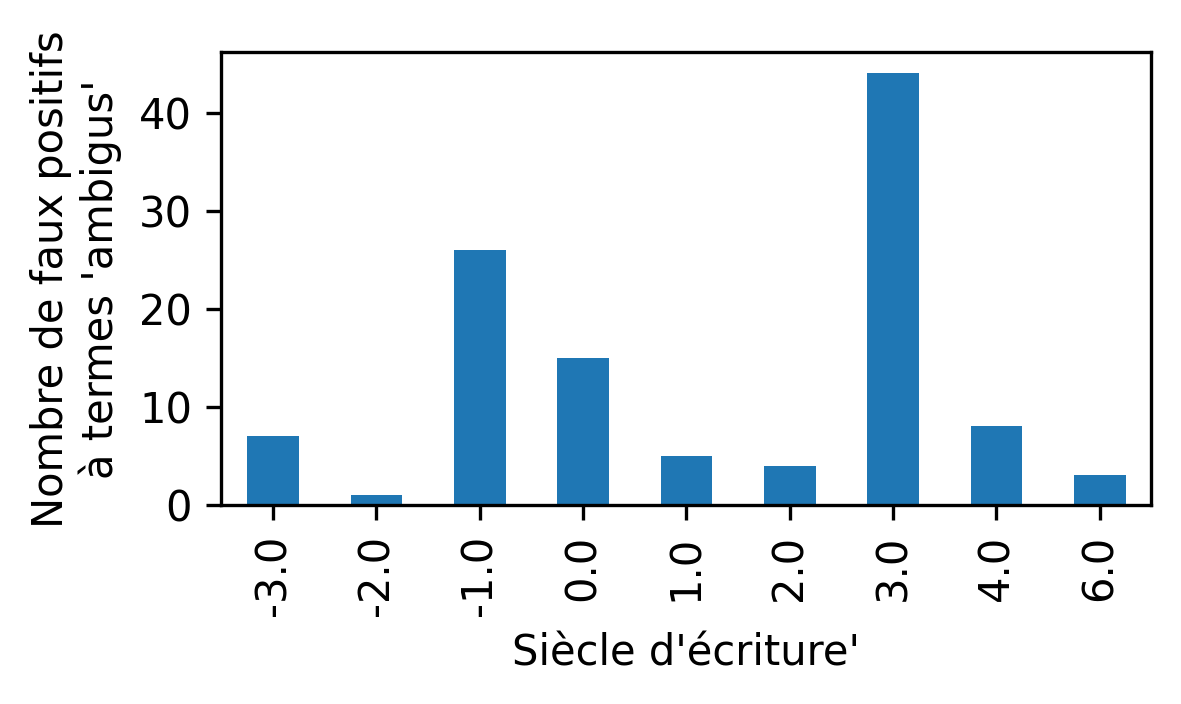

In [20]:
all_fps = attentions[
    (attentions["rank"] == 1) & (attentions.true_positive == False)
][["source"]]

all_fps_source = all_fps.value_counts(["source"]).reset_index()
all_fps_source.columns = ["Source", "Fréquence"]
all_fps_source["Century"] = 0
all_fps_source["Nom"] = ""

all_fps_source = all_fps_source.apply(get_date, axis=1)
all_fps_source = all_fps_source.apply(get_nom, axis=1)


fig = plt.figure(dpi=300, figsize=(4,2))
ax = fig.gca()
all_fps_source.Century.value_counts().reset_index().sort_values("index").plot.bar(x="index", ax=ax)
ax.get_legend().remove()
ax.set_xlabel("Siècle d'écriture'")
ax.set_ylabel("Nombre de faux positifs\nà termes 'ambigus'")


In [21]:
all_fps["Nom"] = ""

def get_nom_wrapped(row):
    row.Source = row.source
    return get_nom(row)

all_fps = all_fps.apply(get_nom_wrapped, axis=1)

all_authors = all_fps.value_counts(["Nom"]).reset_index()
all_authors.columns = ["Nom", "Fréquence"]
all_authors[all_authors.Fréquence > 5]

,Nom,Fréquence
0,Vulgate,83
1,Ovide,77
2,Augustin,42
3,Vindicianus,40
4,Apulée,33
5,Plaute,32
6,Priapées,29
7,Caelius Aurelianus,20
8,"Firmicus Maternus, Julius",20
9,Eucher de Lyon,20


# Faux négatifs

In [3]:
tops = []

Cols = ["word", "lemma", "attention", "median", "std", "true_positive", "source", "model", "rank", "rel_rank"]
Data = namedtuple("Data", Cols)
PATH = "test_dumps/main*HAN*.csv.gz"

models = len(glob.glob(PATH))

occurences = Counter()
all_occurences = Counter()
analysis = defaultdict(list)
sents = defaultdict(list)

for file in tqdm.tqdm(glob.glob(PATH)):
    if "Enriched" in file:
        continue
    #print(file)
    df = pandas.read_csv(file)
    # print(data.head)
    df["attention"] = df["attention"].apply(lambda x: np.array(eval(x)))
    df["ok"] = df["prediction"] == df["label"]

    for i, row in df[df.label == "positive"].iterrows():
        xml = ET.parse(row.fp)
        if not sents[row.fp]:
            sents[row.fp] = list(map(str, xml.xpath("//w/@lemma")))
        lemmas = sents[row.fp]
        if row.ok == True and not analysis[row.fp]:
            analysis[row.fp] = list(map(str, xml.xpath("//w[@ana]/@lemma")))
        row.attention = row.attention[:len(lemmas)]
        occurences += Counter(lemmas)
        all_occurences  += Counter(lemmas)
        med = np.median(row.attention)
        std = row.attention.std()
        quantile = np.quantile(row.attention, 0.74)
        
        ranks = (
            1 + len(lemmas) - (row.attention.argsort().argsort()+1)
        )
        
        words = sorted([
            Data(w, l, a, med, std, row.ok, row.fp, file, rank, (rank-1)/len(lemmas))
            for w, a, l, rank in zip(row.sentence.split(), row.attention, lemmas, ranks)
        ], reverse=True, key=lambda x: x[2])

        for w in words:
            tops.append(w)
            
    for i, row in df[df.label == "negative"].iterrows():
        xml = ET.parse(row.fp)
        if not sents[row.fp]:
            sents[row.fp] = list(map(str, xml.xpath("//w/@lemma")))
        lemmas = sents[row.fp]
        all_occurences += Counter(lemmas)

100%|███████████████████████████████████████████| 40/40 [00:23<00:00,  1.70it/s]


In [9]:
attentions = pandas.DataFrame(tops, columns=Cols).sort_values(
    "attention", ascending=False
)
attentions["difference"] = attentions["attention"] - (attentions["median"] + attentions["std"])
attentions
print(Cols)

['word', 'lemma', 'attention', 'median', 'std', 'true_positive', 'source', 'model', 'rank', 'rel_rank']


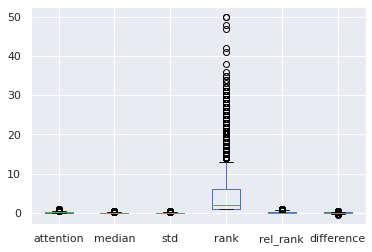

In [13]:
AdamsDf = attentions.copy()
AdamsDf["AdamsRank1"] = False
AdamsDf["Adams"] = False

def adams(row):
    row.Adams = row.lemma in analysis[row.source]
    row.AdamsRank1 = row["rank"] == 1 and row.Adams
    return row


AdamsDf = AdamsDf.apply(adams, axis=1)
AdamsDf[AdamsDf.Adams == True].plot.box("rank")

flt = AdamsDf[AdamsDf.Adams == True]

,attention,median,std,rank,rel_rank,difference
count,5260.000000,5260.000000,5260.000000,5260.000000,5260.000000,5260.000000
mean,0.164185,0.058747,0.059591,4.584981,0.192409,0.045847
std,0.143921,0.053610,0.045434,5.581783,0.248173,0.113704
min,0.001374,0.001765,0.006117,1.000000,0.000000,-0.425011
25%,0.059115,0.024468,0.029305,1.000000,0.000000,-0.026990
50%,0.121715,0.043462,0.046271,2.000000,0.076923,0.021841
75%,0.222329,0.075123,0.075442,6.000000,0.324042,0.100884
max,0.926965,0.454362,0.419858,50.000000,0.970588,0.573596


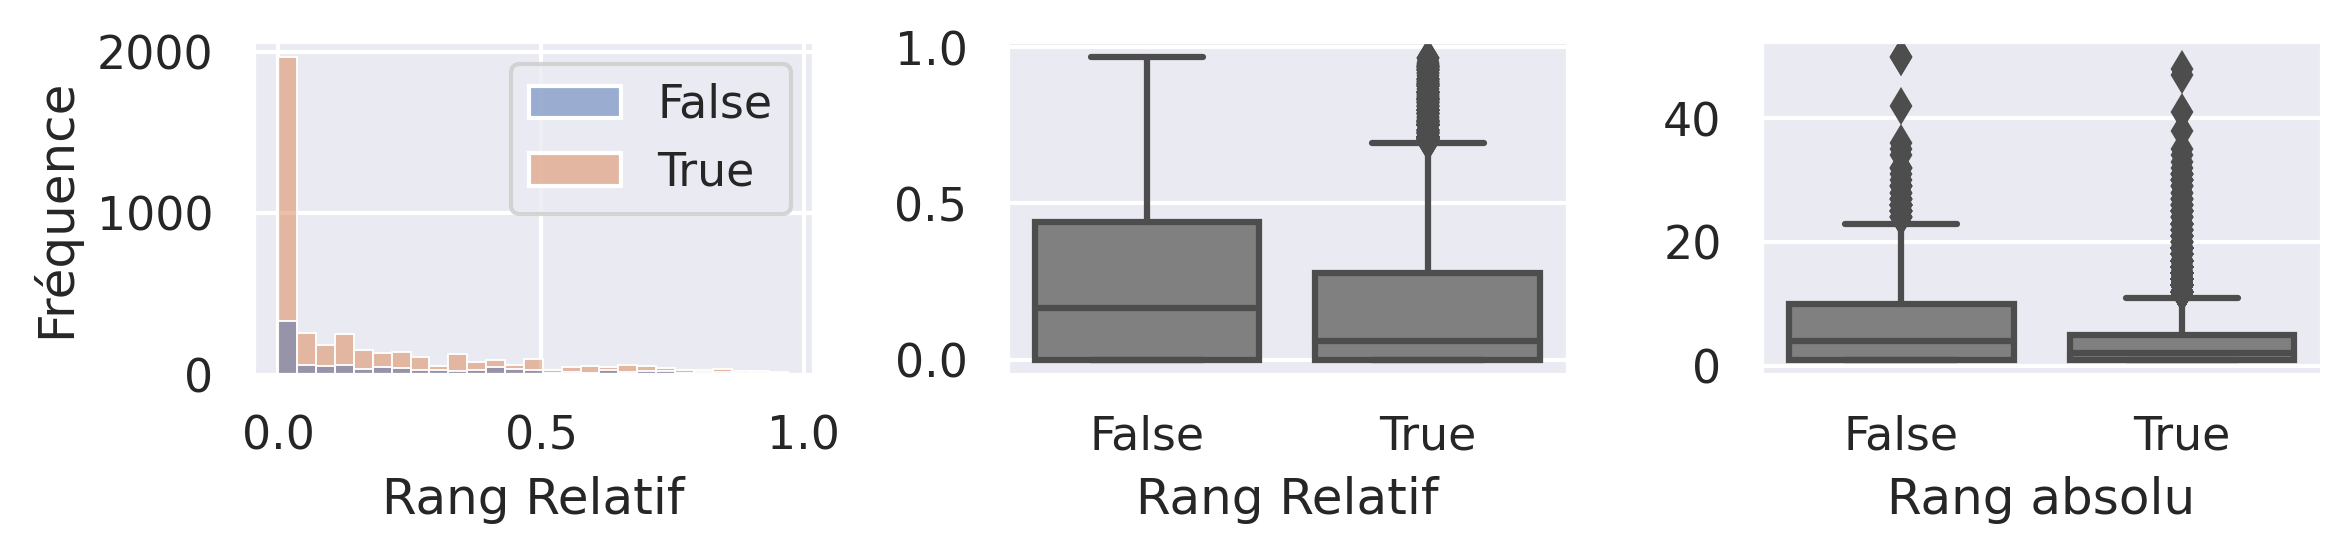

In [20]:

sns.set_theme()
figure, (ax1, ax3, ax2) = plt.subplots(1, 3, dpi=300, figsize=(8,2), tight_layout=True)
sns.histplot(data=flt, x="rel_rank", ax=ax1, hue="true_positive", color="gray")
ax1.set_xlabel("Rang Relatif")
ax1.set_ylabel("Fréquence")

ax1.get_legend().set_title("")
sns.boxplot(data=flt, y="rank", x="true_positive", ax=ax2, color="gray")
ax2.set_ylabel("")
ax2.set_xlabel("Rang absolu")

sns.boxplot(data=flt, y="rel_rank", x="true_positive", ax=ax3, color="gray")
#ax2.set_yticklabels(ax.get_yticks(), rotation = 90)
ax3.set_ylabel("")
ax3.set_xlabel("Rang Relatif")

flt.describe()

In [28]:
fp_texts = attentions[
    (attentions["rank"] == 1) & (attentions.true_positive == False)][["lemma", "attention", "source"]]

fp_texts_counted = fp_texts.value_counts(["lemma", "source"]).reset_index()
fp_texts_counted.columns = ["Lemme", "Source", "Fréquence"]
fp_texts_counted["Century"] = 0

done = []
for idx, row in fp_texts_counted.iterrows():
    #print(row.Lemme, row.Fréquence)
    #print(row.Lemme)
    if row.Source in done:
        continue
    done.append(row.Source)
    xml = ET.parse(row.Source)
    urn = str(xml.xpath("//idno[@type='CTS_URN']/text()")[0])
    #rint(urn)
    display(HTML(str(transform(
        xml,
        lemma=f"'{row.Lemme}'",
        frequence=f"'{row['Fréquence']}'",
        nom=f"\"{names.get(urn, 'Inconnu')}\"",
        siecle=f"'{int(is_nan(dates.get(urn, -999)))}'".replace("-999", "Erreur"),
    ))))
    print("====================\n")